In [1]:
import numpy as np
from scipy import optimize
from sim.cartpole import CartPoleEnv
from agents.sin_agent import SinAgent
import csv
from pyswarms.single.global_best import GlobalBestPSO
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [23]:
render = False
def fun(theta):
    env = CartPoleEnv(swingup=True)
    agent = SinAgent(0.05, 0.3)
    env.x_threshold = 20
    env.masscart = theta[0]
    env.masspole = theta[1]
    env.length = theta[2]
    states = []
    states += [env.reset()]
    if render:
        env.render()
    for _ in range(800):
        states += [env.step(agent.act())[0]]
        if render:
            env.render()
    env.close()
    return np.array(states)

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


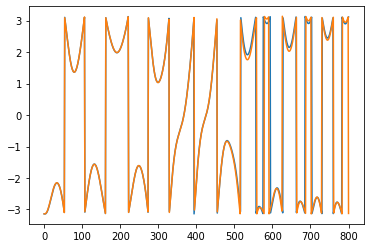

In [24]:
solution_theta = [1.0, 0.1, 0.5]
solution_states = fun(solution_theta)
states = fun(solution_theta)
plt.figure()
plt.plot(states[:,3])
plt.plot(solution_states[:,3])

In [25]:
def loss_(theta):
    states = fun(theta)
    delta_phi = (solution_states[:,[3]] - states[:,[3]]) % (2 * np.pi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)**2
    return (solution_states[:,[0]] - states[:,[0]])**2 + delta_phi

def loss(theta):
    if isinstance(theta[0], float):
        return np.sum(loss_(theta))
    else:
        losses = []
        for t in theta:
            losses += [np.sum(loss(t))]
        return losses

In [26]:
loss(solution_theta)

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.39989980425408533

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8625e+06                                    1.07e+14    
       1              3         3.9567e+05      1.47e+06       2.51e-01       2.71e+12    
       2              6         3.9098e+05      4.69e+03       3.93e-03       1.13e+12    
       3              7         3.8492e+05      6.06e+03       9.81e-04       1.07e+12    
       4              8         3.6036e+05      2.46e+04       2.45e-04       2.26e+12    
       5             16         3.6036e+05      0.00e+00       0.00e+00       2.26e+12    
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 1.8625e+06, final cost 3.6036e+05, first-order optimality 2.26e+12.
 active_mask: array([0., 0., 0.])
        cost: 360357.8504257492
         fun: array([848.94976344])
        grad: array([1.50377398e+12, 2.25959188e+12, 1.16845049e+12])
         jac: array([[1.77133447e+09, 2.66

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


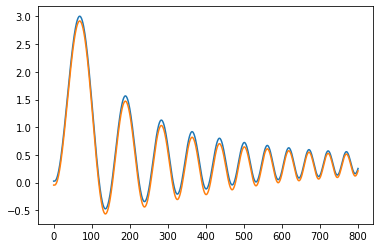

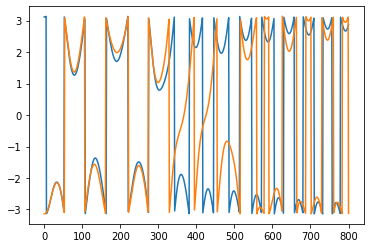

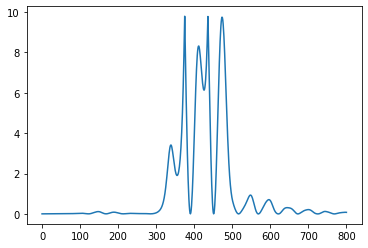

In [27]:
guess = [0.9, 0.2, 0.4]
result = optimize.least_squares(loss, guess, verbose=2)
print(result)
states = fun(result.x)
plt.figure()
plt.plot(states[:,0])
plt.plot(solution_states[:,0])
plt.figure()
plt.plot(states[:,3])
plt.plot(solution_states[:,3])
plt.figure()
plt.plot(loss_(result.x))

In [28]:
bounds = ([0.7, 0.05, 0.3], [1.5, 0.2, 0.7])
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=3, options=options, bounds=bounds)
cost, pos = optimizer.optimize(loss, 200)

2020-03-23 12:39:17,730 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/200/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.0537
2020-03-23 12:40:51,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.05367697484146228, best pos: [1.12643583 0.10903814 0.49913019]


In [29]:
print(solution_theta, pos)

[1.0, 0.1, 0.5] [1.12643583 0.10903814 0.49913019]


In [32]:
result = optimize.least_squares(loss, [1.0, 0.1, 0.5])

In [34]:
print(loss(pos), loss(pos, result.x)

TypeError: loss() takes 1 positional argument but 2 were given